In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [29]:
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, TimeDistributed, Concatenate, RepeatVector, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
from tensorflow.keras import backend as K
logger = tf.get_logger()
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [30]:
plt.rcParams['figure.figsize'] = (12,8)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Note we have reduced the data set to 50K+,50K+ and 25+K Lines considering timelines, resources and cleaned up of garbage data  
# Read the text file content data into Dataframes using pandas libraries.
#----------------------------------------------------------------------------------------------------#
en_europarl_df0 = pd.read_table('/content/europarl-v7_en_de.txt', header=None, names=['English'], encoding='utf-8')
de_europarl_df0 = pd.read_table('/content/europarl-v7_de_en.txt', header=None, names=['German'], encoding='utf-8')

#---------------------------------------------------------------------------------------------------#
en_commoncrawl_df0 = pd.read_table('/content/commoncrawl_en_de.txt', header=None, names=['EN_Commoncrawl'], encoding='utf-8')
de_commoncrawl_df0 = pd.read_table('/content/commoncrawl_de_en.txt', header=None, names=['DE_Commoncrawl'], encoding='utf-8')
#--------------------------------------------------------------------------------------------------#

en_news_commentary_df0 = pd.read_table('/content/news-commentary-v9_en_de.txt', header=None, encoding='utf-8',
                                      lineterminator='\n',names=['EN_News_commentary'])
de_news_commentary_df0 = pd.read_table('/content/news-commentary-v9_de_en.txt', header=None, encoding='utf-8',
                                      lineterminator='\n',names=['DE_News_commentary'])
#--------------------------------------------------------------------------------------------------#

In [33]:
print('\n--------------------------------------------------------\n')
print("English_News_Count: ",en_europarl_df0.count())
print("German_News_Count:  ",de_europarl_df0.count())
print('\n--------------------------------------------------------\n')
print("English_Commoncrawl_Count: ",en_commoncrawl_df0.count())
print("German_Commoncrawl_Count:  ",de_commoncrawl_df0.count())
print('\n--------------------------------------------------------\n')
# We can observe even after spliting the data default at '/n' character only,
# the number of rows on EN and DE side are not matching.
print("English_News_Count: ",en_news_commentary_df0.count())
print("German_News_Count:  ",de_news_commentary_df0.count())
print('\n--------------------------------------------------------\n')
# Same trend of not matching rowcount for EN and DE is obsereved, in this europarl set as well.


--------------------------------------------------------

English_News_Count:  English    20496
dtype: int64
German_News_Count:   German    24281
dtype: int64

--------------------------------------------------------

English_Commoncrawl_Count:  EN_Commoncrawl    36984
dtype: int64
German_Commoncrawl_Count:   DE_Commoncrawl    49823
dtype: int64

--------------------------------------------------------

English_News_Count:  EN_News_commentary    37822
dtype: int64
German_News_Count:   DE_News_commentary    18497
dtype: int64

--------------------------------------------------------



In [34]:
# open the sampled file : europarl_en, 
file_europarl_en = open('/content/europarl-v7_en_de.txt', encoding='utf-8')
file_europarl_de = open('/content/europarl-v7_de_en.txt', encoding='utf-8')
# read the content of the file opened
europarl_en = file_europarl_en.readlines()
europarl_de = file_europarl_de.readlines()
en_europarl_df = pd.DataFrame(europarl_en, columns=['English'])
de_europarl_df = pd.DataFrame(europarl_de, columns = ['German'])
##----------------------------------------------------------------##  
# open the sampled file : commoncrawl_en, commoncrawl_de 
file_commoncrawl_en = open('/content/commoncrawl_en_de.txt', encoding='utf-8')
file_commoncrawl_de = open('/content/commoncrawl_de_en.txt', encoding='utf-8')
# read the content of the file opened
commoncrawl_en = file_commoncrawl_en.readlines()
commoncrawl_de = file_commoncrawl_de.readlines()
en_commoncrawl_df = pd.DataFrame(commoncrawl_en, columns=['EN_commoncrawl'])
de_commoncrawl_df = pd.DataFrame(commoncrawl_de, columns=['DE_commoncrawl'])
##----------------------------------------------------------------##
# open the sampled file : commoncrawl_en, commoncrawl_de 
file_news_commentary_en = open('/content/news-commentary-v9_en_de.txt', encoding='utf-8')
file_news_commentary_de = open('/content/news-commentary-v9_de_en.txt', encoding='utf-8')
# read the content of the file opened
news_commentary_en = file_news_commentary_en.readlines()
news_commentary_de = file_news_commentary_de.readlines()
en_news_commentary_df = pd.DataFrame(news_commentary_en, columns=['EN_News_Commentary'])
de_news_commentary_df = pd.DataFrame(news_commentary_de, columns=['DE_News_Commentary'])
##----------------------------------------------------------------##
print('\n--------------------------------------------------------\n')
print("English_News_Count: ",en_europarl_df.count())
print("German_News_Count:  ",de_europarl_df.count())
print('\n--------------------------------------------------------\n')
# We can observe with UTF encoding and reading the file with stream/list appraoch we were able to success fully load 
# test data into pandas dataframe. 
print("English_Commoncrawl_Count: ",en_commoncrawl_df.count())
print("German_Commoncrawl_Count:  ",de_commoncrawl_df.count())
print('\n--------------------------------------------------------\n')
# the number of rows on EN and DE side are matching.
print("English_News_Count: ",en_news_commentary_df.count())
print("German_News_Count:  ",de_news_commentary_df.count())
print('\n--------------------------------------------------------\n')
# Same trend of matching rowcount for EN and DE is obsereved, in this news commentry set as well.


--------------------------------------------------------

English_News_Count:  English    20572
dtype: int64
German_News_Count:   German    24350
dtype: int64

--------------------------------------------------------

English_Commoncrawl_Count:  EN_commoncrawl    39333
dtype: int64
German_Commoncrawl_Count:   DE_commoncrawl    52493
dtype: int64

--------------------------------------------------------

English_News_Count:  EN_News_Commentary    37970
dtype: int64
German_News_Count:   DE_News_Commentary    18520
dtype: int64

--------------------------------------------------------



In [35]:
#Merge En and DE based DF into one DF
#------------------------------------------------------------------------------------------#
news_commentary_df =  pd.DataFrame()
en_news_commentary_df.join(de_news_commentary_df)
pd.merge(en_news_commentary_df, de_news_commentary_df, left_index=True, right_index=True)
news_commentary_df = pd.concat([en_news_commentary_df, de_news_commentary_df], axis=1)
#------------------------------------------------------------------------------------------#
en_commoncrawl_df.join(de_commoncrawl_df)
pd.merge(en_commoncrawl_df, de_commoncrawl_df, left_index=True, right_index=True)
commoncrawl_df = pd.concat([en_commoncrawl_df, de_commoncrawl_df], axis=1)
#------------------------------------------------------------------------------------------#
en_europarl_df.join(de_europarl_df)
pd.merge(en_europarl_df, de_europarl_df, left_index=True, right_index=True)
europarl_df = pd.concat([en_europarl_df, de_europarl_df], axis=1)
#------------------------------------------------------------------------------------------#

In [36]:
#Free up non-used default allocated memory
del [en_news_commentary_df, de_news_commentary_df,en_news_commentary_df0, de_news_commentary_df0]
del [en_commoncrawl_df, de_commoncrawl_df, en_commoncrawl_df0, de_commoncrawl_df0]
del [en_europarl_df, de_europarl_df, en_europarl_df0, de_europarl_df0]

In [37]:
#Step 2A: Merge all the three datasets. [ 1 point ]
df =  pd.DataFrame()
event_df=  pd.DataFrame()
#------------------------------------------------------------------------------------------#
news_commentary_df.join(commoncrawl_df)
pd.merge(news_commentary_df, commoncrawl_df, left_index=True, right_index=True)
event_df = pd.concat([news_commentary_df, commoncrawl_df], axis=1)
#------------------------------------------------------------------------------------------#
event_df.join(europarl_df)
pd.merge(event_df, europarl_df, left_index=True, right_index=True)
df = pd.concat([event_df, europarl_df], axis=1)
#------------------------------------------------------------------------------------------#
#Free up non-used default allocated memory
del [event_df]

In [38]:
df.duplicated().sum()

0

In [39]:
df = df.drop_duplicates()

In [40]:
df.duplicated().sum()

0

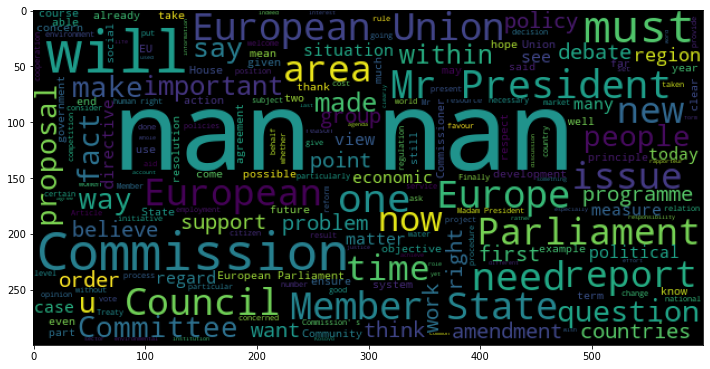

In [41]:
wc_en = WordCloud(width=600,height=300).generate(' '.join(map(str,df.English)))
plt.imshow(wc_en);

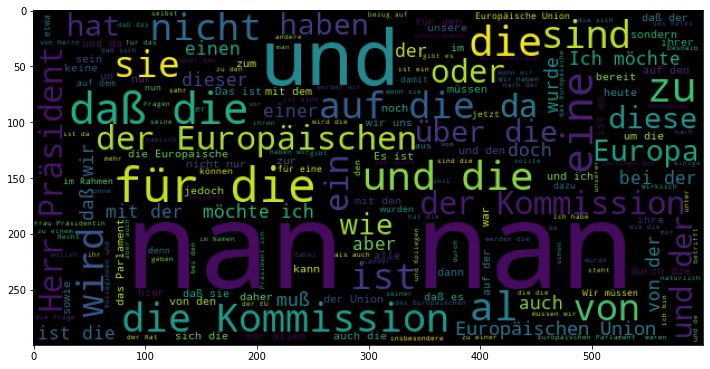

In [42]:
wc_de = WordCloud(width=600,height=300).generate(' '.join(map(str,df.German)))
plt.imshow(wc_de);

In [43]:
df['eng_len'] = df.English.apply(str,len)
df['ger_len'] = df.German.apply(str,len)

In [44]:
df.describe()

EN_News_Commentary DE_News_Commentary  \
count               37970              18520   
unique              37681              18458   
top                    \n                 \n   
freq                   46                 23   

                                           EN_commoncrawl  \
count                                               39333   
unique                                              38995   
top     All special requests are subject to availabili...   
freq                                                    6   

                                           DE_commoncrawl English German  \
count                                               52493   20572  24350   
unique                                              52493   20193  23920   
top     iron cement ist eine gebrauchs-fertige Paste, ...      \n     \n   
freq                                                    1      73     66   

       eng_len ger_len  
count    52493   52493  
unique   20194   23921  
top        nan     nan  
freq     31921   28143

In [45]:
max_eng_len = 100
max_ger_len = 100

In [46]:
def clean_text(text):
    text = text.lower()  
    pattern = re.compile('\W')
    text = re.sub(pattern,' ',text).strip()
    return text

In [47]:
df.English = df.English.progress_apply(str,clean_text)
df.German = df.German.progress_apply(str,clean_text)

  0%|          | 0/52493 [00:00<?, ?it/s]

  0%|          | 0/52493 [00:00<?, ?it/s]

In [48]:
df.German = df.German.apply(lambda x: '<START> ' + x + ' <END>')

In [49]:
df.German.head()

0    <START> Wiederaufnahme der Sitzungsperiode\n <...
1    <START> Ich erkläre die am Freitag, dem 17. De...
2    <START> Wie Sie feststellen konnten, ist der g...
3    <START> Im Parlament besteht der Wunsch nach e...
4    <START> Heute möchte ich Sie bitten - das ist ...
Name: German, dtype: object

In [50]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df.English.head(6000))

In [51]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_vocab_size

8792

In [52]:
eng_sequences = eng_tokenizer.texts_to_sequences(df.English.head(6000))
eng_pad_sequences = pad_sequences(eng_sequences,maxlen=max_eng_len,dtype='int32',padding='post',truncating='post')

In [53]:
ger_tokenizer = Tokenizer()
ger_tokenizer.fit_on_texts(df.German.head(6000))

In [54]:
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_vocab_size

14451

In [55]:
ger_sequences = ger_tokenizer.texts_to_sequences(df.German.head(6000))
ger_pad_sequences = pad_sequences(ger_sequences,maxlen=max_ger_len,dtype='int32',padding='post',truncating='post')

In [56]:
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [57]:
K.clear_session()

latent_dim = 300 
embedding_dim = 100 

encoder_inputs = Input(shape=(max_eng_len,))
encoder_emb = Embedding(eng_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_output2)
encoder_states = [state_h,state_c]

decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(ger_vocab_size, embedding_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_bwd_state = decoder_lstm(decoder_emb, initial_state=encoder_states) 

attn_layer = AttentionLayer(name='attention_layer') 
attn_outputs, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_outputs = Concatenate(axis=-1,name='concat_layer')([decoder_outputs, attn_outputs])

decoder_dense = TimeDistributed(Dense(ger_vocab_size,activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     879200      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

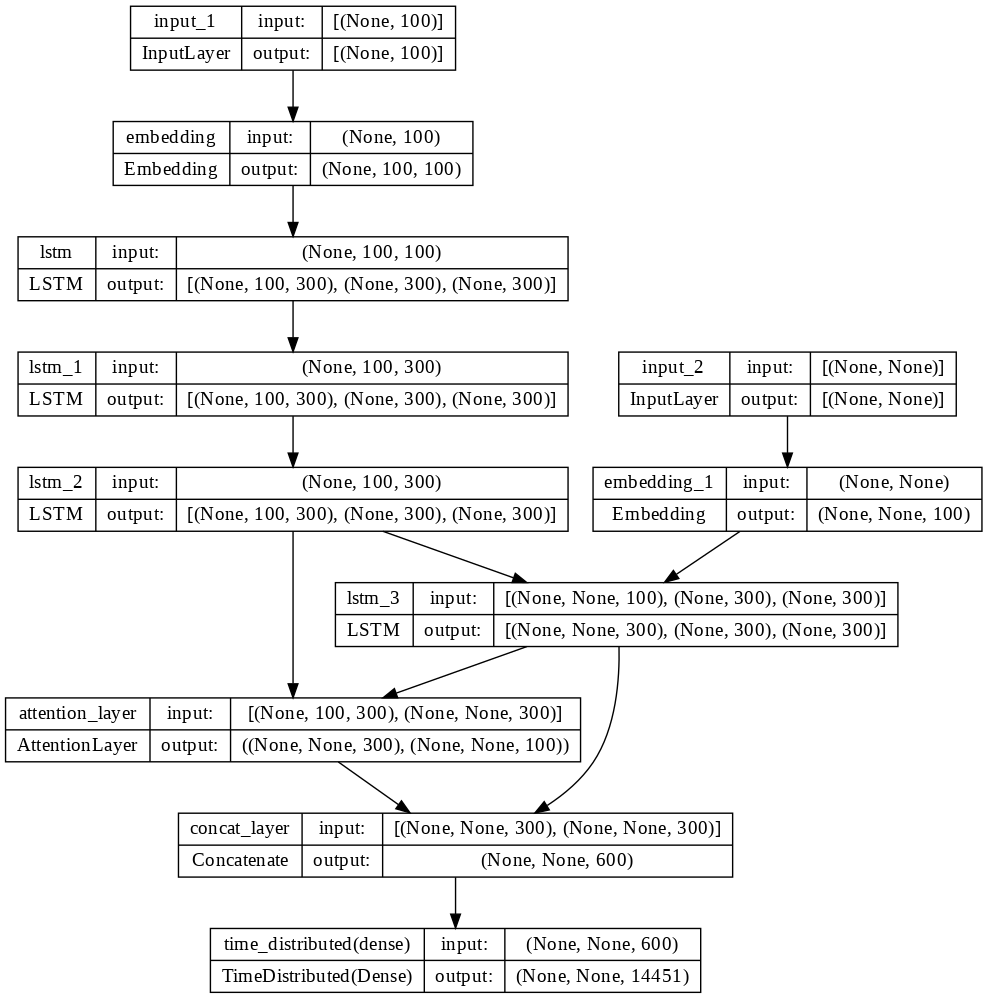

In [58]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

In [59]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')

In [60]:
 X_train, X_test, y_train, y_test = train_test_split(eng_pad_sequences,ger_pad_sequences,test_size=0.25,shuffle=True,random_state=101)

In [61]:
es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=40)
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',verbose=1,patience=5,factor=0.1,min_lr=0.001)
mc = ModelCheckpoint('checkpoint/',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

r = model.fit([X_train,y_train[:,:-1]],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1)[:,1:],
             epochs=50,
             batch_size=256,
             callbacks=[es,rl,mc],
             validation_data=([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:]))

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 3.2171 - accuracy: 0.7127
Epoch 1: val_accuracy improved from -inf to 0.75904, saving model to checkpoint/


18/18 [==============================] - 86s 4s/step - loss: 3.2171 - accuracy: 0.7127 - val_loss: 1.9534 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 1.9341 - accuracy: 0.7573
Epoch 2: val_accuracy improved from 0.75904 to 0.75954, saving model to checkpoint/


18/18 [==============================] - 64s 4s/step - loss: 1.9341 - accuracy: 0.7573 - val_loss: 1.8759 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.7727 - accuracy: 0.7580
Epoch 3: val_accuracy improved from 0.75954 to 0.76125, saving model to checkpoint/


18/18 [==============================] - 63s 4s/step - loss: 1.7727 - accuracy: 0.7580 - val_loss: 1.7622 - val_accuracy: 0.7612 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 1.7181 - accuracy: 0.7607
Epoch 4: val_accuracy improved from 0.76125 to 0.76354, saving model to checkpoint/


18/18 [==============================] - 64s 4s/step - loss: 1.7181 - accuracy: 0.7607 - val_loss: 1.7355 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 5/50
18/18 [==============================] - ETA: 0s - loss: 1.6873 - accuracy: 0.7649
Epoch 5: val_accuracy improved from 0.76354 to 0.76848, saving model to checkpoint/


18/18 [==============================] - 65s 4s/step - loss: 1.6873 - accuracy: 0.7649 - val_loss: 1.7279 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 6/50
18/18 [==============================] - ETA: 0s - loss: 1.6623 - accuracy: 0.7693
Epoch 6: val_accuracy improved from 0.76848 to 0.77195, saving model to checkpoint/


18/18 [==============================] - 64s 4s/step - loss: 1.6623 - accuracy: 0.7693 - val_loss: 1.7186 - val_accuracy: 0.7719 - lr: 0.0010
Epoch 7/50
18/18 [==============================] - ETA: 0s - loss: 1.6303 - accuracy: 0.7732
Epoch 7: val_accuracy improved from 0.77195 to 0.77601, saving model to checkpoint/


18/18 [==============================] - 66s 4s/step - loss: 1.6303 - accuracy: 0.7732 - val_loss: 1.6819 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 8/50
18/18 [==============================] - ETA: 0s - loss: 1.5942 - accuracy: 0.7753
Epoch 8: val_accuracy improved from 0.77601 to 0.77715, saving model to checkpoint/


18/18 [==============================] - 65s 4s/step - loss: 1.5942 - accuracy: 0.7753 - val_loss: 1.6603 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 9/50
18/18 [==============================] - ETA: 0s - loss: 1.5642 - accuracy: 0.7763
Epoch 9: val_accuracy improved from 0.77715 to 0.77719, saving model to checkpoint/


18/18 [==============================] - 65s 4s/step - loss: 1.5642 - accuracy: 0.7763 - val_loss: 1.6555 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 10/50
18/18 [==============================] - ETA: 0s - loss: 1.5397 - accuracy: 0.7773
Epoch 10: val_accuracy did not improve from 0.77719
18/18 [==============================] - 50s 3s/step - loss: 1.5397 - accuracy: 0.7773 - val_loss: 2.1989 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 11/50
18/18 [==============================] - ETA: 0s - loss: 1.5582 - accuracy: 0.7769
Epoch 11: val_accuracy improved from 0.77719 to 0.77861, saving model to checkpoint/


18/18 [==============================] - 65s 4s/step - loss: 1.5582 - accuracy: 0.7769 - val_loss: 1.6445 - val_accuracy: 0.7786 - lr: 0.0010
Epoch 12/50
18/18 [==============================] - ETA: 0s - loss: 1.5015 - accuracy: 0.7783
Epoch 12: val_accuracy improved from 0.77861 to 0.77894, saving model to checkpoint/


18/18 [==============================] - 65s 4s/step - loss: 1.5015 - accuracy: 0.7783 - val_loss: 1.6295 - val_accuracy: 0.7789 - lr: 0.0010
Epoch 13/50
18/18 [==============================] - ETA: 0s - loss: 1.4858 - accuracy: 0.7786
Epoch 13: val_accuracy improved from 0.77894 to 0.77906, saving model to checkpoint/


18/18 [==============================] - 63s 4s/step - loss: 1.4858 - accuracy: 0.7786 - val_loss: 1.6290 - val_accuracy: 0.7791 - lr: 0.0010
Epoch 14/50
18/18 [==============================] - ETA: 0s - loss: 1.4664 - accuracy: 0.7792
Epoch 14: val_accuracy improved from 0.77906 to 0.77978, saving model to checkpoint/


18/18 [==============================] - 64s 4s/step - loss: 1.4664 - accuracy: 0.7792 - val_loss: 1.6239 - val_accuracy: 0.7798 - lr: 0.0010
Epoch 15/50
18/18 [==============================] - ETA: 0s - loss: 1.4474 - accuracy: 0.7795
Epoch 15: val_accuracy improved from 0.77978 to 0.78002, saving model to checkpoint/


18/18 [==============================] - 65s 4s/step - loss: 1.4474 - accuracy: 0.7795 - val_loss: 1.6235 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 16/50
18/18 [==============================] - ETA: 0s - loss: 1.4318 - accuracy: 0.7799
Epoch 16: val_accuracy improved from 0.78002 to 0.78024, saving model to checkpoint/


18/18 [==============================] - 63s 4s/step - loss: 1.4318 - accuracy: 0.7799 - val_loss: 1.6229 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 17/50
18/18 [==============================] - ETA: 0s - loss: 1.4153 - accuracy: 0.7806
Epoch 17: val_accuracy improved from 0.78024 to 0.78053, saving model to checkpoint/


18/18 [==============================] - 64s 4s/step - loss: 1.4153 - accuracy: 0.7806 - val_loss: 1.6251 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 18/50
18/18 [==============================] - ETA: 0s - loss: 1.3976 - accuracy: 0.7813
Epoch 18: val_accuracy improved from 0.78053 to 0.78084, saving model to checkpoint/


18/18 [==============================] - 64s 4s/step - loss: 1.3976 - accuracy: 0.7813 - val_loss: 1.6228 - val_accuracy: 0.7808 - lr: 0.0010
Epoch 19/50
18/18 [==============================] - ETA: 0s - loss: 1.3824 - accuracy: 0.7815
Epoch 19: val_accuracy improved from 0.78084 to 0.78164, saving model to checkpoint/


18/18 [==============================] - 66s 4s/step - loss: 1.3824 - accuracy: 0.7815 - val_loss: 1.6199 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 20/50
18/18 [==============================] - ETA: 0s - loss: 1.3685 - accuracy: 0.7826
Epoch 20: val_accuracy improved from 0.78164 to 0.78263, saving model to checkpoint/


18/18 [==============================] - 63s 4s/step - loss: 1.3685 - accuracy: 0.7826 - val_loss: 1.6171 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 21/50
18/18 [==============================] - ETA: 0s - loss: 1.3522 - accuracy: 0.7832
Epoch 21: val_accuracy improved from 0.78263 to 0.78289, saving model to checkpoint/


18/18 [==============================] - 63s 4s/step - loss: 1.3522 - accuracy: 0.7832 - val_loss: 1.6151 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 22/50
18/18 [==============================] - ETA: 0s - loss: 1.3316 - accuracy: 0.7841
Epoch 22: val_accuracy improved from 0.78289 to 0.78314, saving model to checkpoint/


18/18 [==============================] - 65s 4s/step - loss: 1.3316 - accuracy: 0.7841 - val_loss: 1.6149 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 23/50
18/18 [==============================] - ETA: 0s - loss: 1.3167 - accuracy: 0.7846
Epoch 23: val_accuracy improved from 0.78314 to 0.78439, saving model to checkpoint/


18/18 [==============================] - 64s 4s/step - loss: 1.3167 - accuracy: 0.7846 - val_loss: 1.6102 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 24/50
18/18 [==============================] - ETA: 0s - loss: 1.3015 - accuracy: 0.7853
Epoch 24: val_accuracy did not improve from 0.78439
18/18 [==============================] - 51s 3s/step - loss: 1.3015 - accuracy: 0.7853 - val_loss: 1.6094 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 25/50
18/18 [==============================] - ETA: 0s - loss: 1.2840 - accuracy: 0.7861
Epoch 25: val_accuracy improved from 0.78439 to 0.78449, saving model to checkpoint/


18/18 [==============================] - 64s 4s/step - loss: 1.2840 - accuracy: 0.7861 - val_loss: 1.6122 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 26/50
18/18 [==============================] - ETA: 0s - loss: 1.2667 - accuracy: 0.7867
Epoch 26: val_accuracy improved from 0.78449 to 0.78492, saving model to checkpoint/


18/18 [==============================] - 65s 4s/step - loss: 1.2667 - accuracy: 0.7867 - val_loss: 1.6187 - val_accuracy: 0.7849 - lr: 0.0010
Epoch 27/50
18/18 [==============================] - ETA: 0s - loss: 1.2514 - accuracy: 0.7875
Epoch 27: val_accuracy improved from 0.78492 to 0.78517, saving model to checkpoint/


18/18 [==============================] - 64s 4s/step - loss: 1.2514 - accuracy: 0.7875 - val_loss: 1.6129 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 28/50
18/18 [==============================] - ETA: 0s - loss: 1.2347 - accuracy: 0.7882
Epoch 28: val_accuracy improved from 0.78517 to 0.78560, saving model to checkpoint/


18/18 [==============================] - 64s 4s/step - loss: 1.2347 - accuracy: 0.7882 - val_loss: 1.6105 - val_accuracy: 0.7856 - lr: 0.0010
Epoch 29/50
18/18 [==============================] - ETA: 0s - loss: 1.2164 - accuracy: 0.7895
Epoch 29: val_accuracy improved from 0.78560 to 0.78634, saving model to checkpoint/


18/18 [==============================] - 66s 4s/step - loss: 1.2164 - accuracy: 0.7895 - val_loss: 1.6102 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 30/50
18/18 [==============================] - ETA: 0s - loss: 1.1979 - accuracy: 0.7908
Epoch 30: val_accuracy did not improve from 0.78634
18/18 [==============================] - 52s 3s/step - loss: 1.1979 - accuracy: 0.7908 - val_loss: 1.6129 - val_accuracy: 0.7862 - lr: 0.0010
Epoch 31/50
18/18 [==============================] - ETA: 0s - loss: 1.1840 - accuracy: 0.7920
Epoch 31: val_accuracy improved from 0.78634 to 0.78648, saving model to checkpoint/


18/18 [==============================] - 65s 4s/step - loss: 1.1840 - accuracy: 0.7920 - val_loss: 1.6109 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 32/50
18/18 [==============================] - ETA: 0s - loss: 1.1641 - accuracy: 0.7941
Epoch 32: val_accuracy improved from 0.78648 to 0.78669, saving model to checkpoint/


18/18 [==============================] - 63s 4s/step - loss: 1.1641 - accuracy: 0.7941 - val_loss: 1.6140 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 33/50
18/18 [==============================] - ETA: 0s - loss: 1.1487 - accuracy: 0.7953
Epoch 33: val_accuracy improved from 0.78669 to 0.78710, saving model to checkpoint/


18/18 [==============================] - 63s 4s/step - loss: 1.1487 - accuracy: 0.7953 - val_loss: 1.6126 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 34/50
18/18 [==============================] - ETA: 0s - loss: 1.1308 - accuracy: 0.7973
Epoch 34: val_accuracy did not improve from 0.78710
18/18 [==============================] - 51s 3s/step - loss: 1.1308 - accuracy: 0.7973 - val_loss: 1.6185 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 35/50
18/18 [==============================] - ETA: 0s - loss: 1.1145 - accuracy: 0.7995
Epoch 35: val_accuracy improved from 0.78710 to 0.78794, saving model to checkpoint/


18/18 [==============================] - 62s 4s/step - loss: 1.1145 - accuracy: 0.7995 - val_loss: 1.6139 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 36/50
18/18 [==============================] - ETA: 0s - loss: 1.0960 - accuracy: 0.8012
Epoch 36: val_accuracy did not improve from 0.78794
18/18 [==============================] - 51s 3s/step - loss: 1.0960 - accuracy: 0.8012 - val_loss: 1.6239 - val_accuracy: 0.7866 - lr: 0.0010
Epoch 37/50
18/18 [==============================] - ETA: 0s - loss: 1.0812 - accuracy: 0.8025
Epoch 37: val_accuracy did not improve from 0.78794
18/18 [==============================] - 52s 3s/step - loss: 1.0812 - accuracy: 0.8025 - val_loss: 1.6158 - val_accuracy: 0.7874 - lr: 0.0010
Epoch 38/50
18/18 [==============================] - ETA: 0s - loss: 1.0625 - accuracy: 0.8048
Epoch 38: val_accuracy did not improve from 0.78794
18/18 [==============================] - 49s 3s/step - loss: 1.0625 - accuracy: 0.8048 - val_loss: 1.6187 - val_accuracy: 0.7874 - lr

18/18 [==============================] - 64s 4s/step - loss: 1.0289 - accuracy: 0.8086 - val_loss: 1.6198 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 41/50
18/18 [==============================] - ETA: 0s - loss: 1.0134 - accuracy: 0.8107
Epoch 41: val_accuracy did not improve from 0.78838
18/18 [==============================] - 50s 3s/step - loss: 1.0134 - accuracy: 0.8107 - val_loss: 1.6235 - val_accuracy: 0.7876 - lr: 0.0010
Epoch 42/50
18/18 [==============================] - ETA: 0s - loss: 0.9983 - accuracy: 0.8125
Epoch 42: val_accuracy did not improve from 0.78838
18/18 [==============================] - 52s 3s/step - loss: 0.9983 - accuracy: 0.8125 - val_loss: 1.6247 - val_accuracy: 0.7878 - lr: 0.0010
Epoch 43/50
18/18 [==============================] - ETA: 0s - loss: 0.9823 - accuracy: 0.8143
Epoch 43: val_accuracy did not improve from 0.78838
18/18 [==============================] - 51s 3s/step - loss: 0.9823 - accuracy: 0.8143 - val_loss: 1.6311 - val_accuracy: 0.7870 - lr

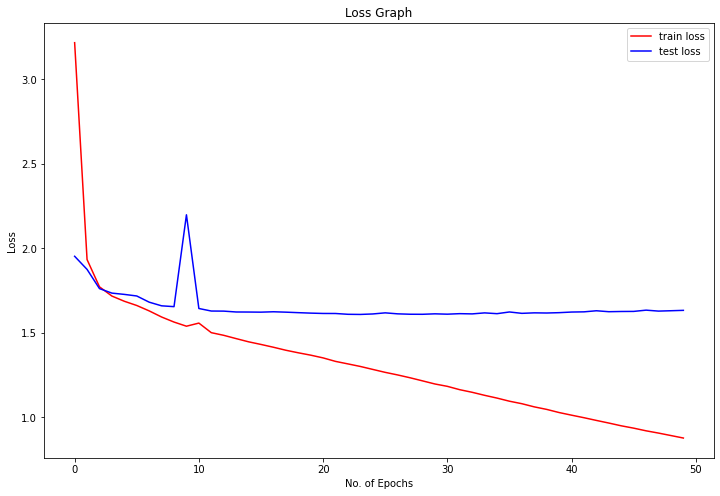

In [62]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

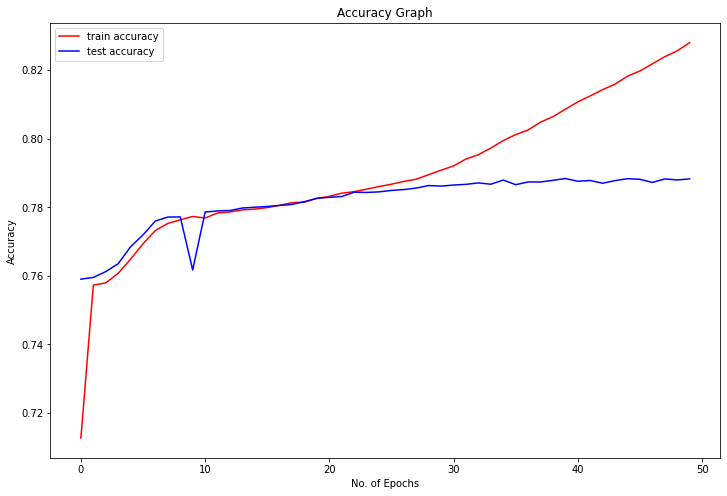

In [63]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [64]:
model.evaluate([X_test,y_test[:,:-1]],y_test.reshape(y_test.shape[0],y_test.shape[1],1)[:,1:])

47/47 [==============================] - 8s 165ms/step - loss: 1.6335 - accuracy: 0.7883


[1.6335225105285645, 0.7882760763168335]

In [65]:
model.save('english_to_german_translator_er_f.h5')
lm = load_model('english_to_german_translator_er_f.h5',custom_objects={'AttentionLayer': AttentionLayer})

In [66]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_initial_state_a = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))
decoder_hidden_state = Input(shape=(max_eng_len, latent_dim))

decoder_out, decoder_state_a, decoder_state_c = decoder_lstm(decoder_emb, initial_state=[decoder_initial_state_a, decoder_initial_state_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state, decoder_out])
decoder_inf_concat_outputs = Concatenate(axis=-1, name='concat')([decoder_out, attn_out_inf])

decoder_final = decoder_dense(decoder_inf_concat_outputs)
decoder_model = Model([decoder_inputs]+[decoder_hidden_state, decoder_initial_state_a, decoder_initial_state_c], [decoder_final]+[decoder_state_a, decoder_state_c])

In [67]:
def decode_sequences(input_sequence):
    encoder_out, encoder_a, encoder_c = encoder_model.predict(input_sequence)
    next_input = np.zeros((1,1))
    next_input[0,0] = ger_tokenizer.word_index['start']
    output_sequence = ''
    flag = False
    while not flag:
        decoded_out, trans_state_a, trans_state_c = decoder_model.predict([next_input] + [encoder_out, encoder_a, encoder_c])
        output_idx = np.argmax(decoded_out[0, -1, :])
        if output_idx == ger_tokenizer.word_index['end']: 
            flag = True
        elif output_idx > 0 and output_idx != ger_tokenizer.word_index['start']:
            output_token = ger_tokenizer.index_word[output_idx] 
            output_sequence = output_sequence + ' ' + output_token 
        next_input[0,0] = output_idx
        # Continously update the transient state vectors in decoder.
        encoder_a, encoder_c = trans_state_a, trans_state_c
        
    return output_sequence     

In [68]:
def sequence_to_language(input_sequence,tokenizer,lang):
    res = ''
    
    if lang == 'eng':
        for idx in input_sequence:
            if idx != 0:
                res = res + tokenizer.index_word[idx] + ' '
    
    elif lang == 'ger':
        for idx in input_sequence:
            if idx > 0:
                if tokenizer.index_word[idx] != 'start' and tokenizer.index_word[idx] != 'end':
                    res = res + tokenizer.index_word[idx] + ' '
                    
    return res

In [69]:
def predicted_sequence_to_ger_language(input_sequence):
    res = ''
    
    for idx in input_sequence:
        if idx > 0:
            if ger_tokenizer.index_word[idx] != 'start' and ger_tokenizer.index_word[idx] != 'end':
                res = res + ger_tokenizer.index_word[idx] + ' '
    
    return res

In [70]:
predicted_ger_translations= []

for i in range(21, 39):
    print("English Sentence:",sequence_to_language(X_test[i],eng_tokenizer,'eng'))
    print("Original German Translation:",sequence_to_language(y_test[i],ger_tokenizer,'ger'))
    pred_german_sentence = decode_sequences(X_test[i].reshape(1,max_eng_len))
    print("Predicted German Translation:",pred_german_sentence)
    predicted_ger_translations.append(pred_german_sentence)

English Sentence: however i come from an area in northern germany where the forestry industry predominates and i can tell you that we are already feeling the effects of the immense damage 
Original German Translation: doch ich komme selbst aus einer forstwirtschaft im norden deutschlands und ich sage ihnen daß wir in unserer region schon jetzt diese immensen schäden spüren 
1/1 [==============================] - 0s 23ms/step
Predicted German Translation:  ich möchte ich nicht feststellen daß die israelische qualifikation der beruflichen qualifikation der europäischen union und die beitrittskandidat der vereinigten staaten und vorgegangen werden
English Sentence: frankly i believe that this modernisation has been satisfactory 
Original German Translation: offen gesagt glaube ich daß diese modernisierung zufriedenstellend gewesen ist 
1/1 [==============================] - 0s 24ms/step
Predicted German Translation:  ich möchte ich nicht folgendes sagen
English Sentence: madam president i

In [71]:
original_ger_translations = []
for i in range(20):
    original_ger_translations.append(sequence_to_language(y_test[i],ger_tokenizer,'ger'))
references = []

for trans in original_ger_translations:
    ref = trans.split()
    references.append(ref)

In [72]:
orig_ger_sents = []
smooth = SmoothingFunction().method4

for i in range(0, 16):
    print("Original German Sentence:",references[i])
    print("Predicted German Sentence:",predicted_ger_translations[i])
    print("BLEU Score:",sentence_bleu(references[i],predicted_ger_translations[i],weights=(0.25,0.25,0.25,0.25)))

Original German Sentence: ['ich', 'behaupte', 'jedoch', 'er', 'kann', 'und', 'will', 'genauso', 'wenig', 'wie', 'andere', 'rechtsextreme', 'bewegungen', 'in', 'dieses', 'in', 'unser', 'politisches', 'system', 'und', 'in', 'dieses', 'europa', 'integriert', 'werden']
Predicted German Sentence:  ich möchte ich nicht feststellen daß die israelische qualifikation der beruflichen qualifikation der europäischen union und die beitrittskandidat der vereinigten staaten und vorgegangen werden
BLEU Score: 0.11030175987550071
Original German Sentence: ['was', 'können', 'nun', 'die', 'abgeordneten', 'des', 'europäischen', 'parlaments', 'angesichts', 'einer', 'derartigen', 'katastrophe', 'tun']
Predicted German Sentence:  ich möchte ich nicht folgendes sagen
BLEU Score: 0.14175297978092313
Original German Sentence: ['ohne', 'schwäche', 'ohne', 'selbstgefälligkeit', 'ohne', 'zweideutigkeit', 'aber', 'im', 'dienste', 'der', 'gesamten', 'union', 'und', 'jedes', 'einzelnen', 'mitgliedstaats', 'und', 'sei